# Sales Prediction

Using machine learning to help organization prepare to handle dynamic market demand. Organization may infer the prediction to establish rule, plan, or strategy to further strengthen market position.

## Library Import and Configuration

In [71]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

from util.dbconn import DbConn

In [72]:
WAREHOUSE_CONN = {
    'user': 'postgres',
    'password': 'qshOke46RvOg0',
    'host': '10.182.0.3',
    'port': '8084',
    'dbname': 'postgres'
}

In [73]:
postgres_conn = DbConn(WAREHOUSE_CONN).get_conn()

## Data Overview

In [74]:
sql = """SELECT 
	dd."year",
	dd."month",
	dd.week_num_in_year,
	dd."date",
    dd.weekday_flag,
    dd.day_of_week,
	count(DISTINCT fo.order_legacy_id) as count_order
FROM 
	warehouse.fact_order fo
LEFT JOIN warehouse.date_dim dd ON
	fo.order_date = dd.date_id
GROUP BY 1,2,3,4,5,6;
"""

In [75]:
df = pd.read_sql(sql=sql, con=postgres_conn)

display(df.info())
display(df.describe())
display(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   year              634 non-null    int64
 1   month             634 non-null    int64
 2   week_num_in_year  634 non-null    int64
 3   date              634 non-null    int64
 4   weekday_flag      634 non-null    bool 
 5   day_of_week       634 non-null    int64
 6   count_order       634 non-null    int64
dtypes: bool(1), int64(6)
memory usage: 30.5 KB


None

,year,month,week_num_in_year,date,day_of_week,count_order
count,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000
mean,2017.383281,5.938486,24.501577,15.597792,3.971609,156.847003
std,0.533051,3.214452,14.111411,8.768610,2.002167,94.224817
min,2016.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2017.000000,3.000000,13.000000,8.000000,2.000000,96.000000
50%,2017.000000,6.000000,24.000000,15.500000,4.000000,148.000000
75%,2018.000000,8.000000,35.000000,23.000000,6.000000,215.750000
max,2018.000000,12.000000,53.000000,31.000000,7.000000,1176.000000


,year,month,week_num_in_year,date,weekday_flag,day_of_week,count_order
0,2016,9,36,4,False,7,1
1,2016,9,37,5,True,1,1
2,2016,9,38,13,True,2,1
3,2016,9,38,15,True,4,1
4,2016,10,40,2,False,7,1


### Check Null Values

In [76]:
df.isnull().sum()

year                0
month               0
week_num_in_year    0
date                0
weekday_flag        0
day_of_week         0
count_order         0
dtype: int64

## Exploratory Data Analysis

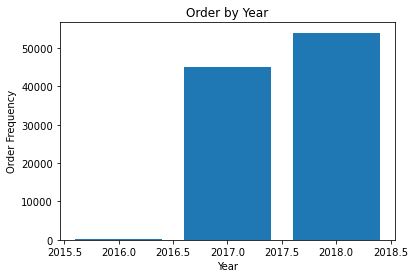

,year,count_order
0,2016,329
1,2017,45101
2,2018,54011


In [84]:
fig, ax = plt.subplots()

_df_temp = df.loc[:, ['year', 'count_order']].groupby('year', as_index=False).sum()

ax.bar(_df_temp['year'], _df_temp['count_order'])
ax.set_title('Order by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Order Frequency')

plt.show()
display(_df_temp.head(15))

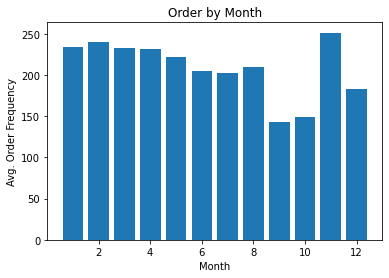

,year,month,count_order
0,2016,9,1.000000
1,2016,10,32.400000
2,2016,12,1.000000
3,2017,1,29.629630
4,2017,2,63.571429
5,2017,3,86.516129
6,2017,4,80.133333
7,2017,5,119.354839
8,2017,6,108.166667
9,2017,7,129.870968


In [81]:
fig, ax = plt.subplots()

_df_temp = df.loc[:, ['year', 'month', 'count_order']] \
            .groupby(by=['year', 'month'], as_index=False) \
            .mean()

ax.bar(_df_temp['month'], _df_temp['count_order'])
ax.set_title('Order by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Avg. Order Frequency')

plt.show()
display(_df_temp.head(15))

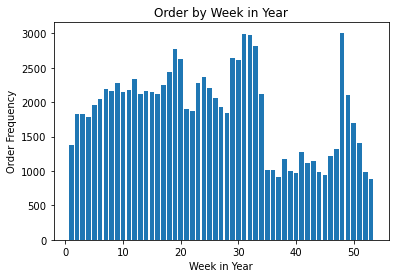

,week_num_in_year,count_order
0,1,1383
1,2,1831
2,3,1830
3,4,1788
4,5,1952
5,6,2051
6,7,2188
7,8,2167
8,9,2282
9,10,2140


In [9]:
fig, ax = plt.subplots()

_df_temp = df.loc[:, ['week_num_in_year', 'count_order']] \
            .groupby(by='week_num_in_year', as_index=False) \
            .sum()

ax.bar(_df_temp['week_num_in_year'], _df_temp['count_order'])
ax.set_title('Order by Week in Year')
ax.set_xlabel('Week in Year')
ax.set_ylabel('Order Frequency')

plt.show()
display(_df_temp.head(15))

In [10]:
model_df = df.copy()

## Data Preprocessing

In [11]:
from sklearn.preprocessing import StandardScaler
standardize = StandardScaler()

model_df['weekday_flag'] = model_df['weekday_flag'].astype(int)

## Utility Functions

In [12]:
def _tscv(X, pipe):
    tscv = TimeSeriesSplit()

    errors = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        mse = mean_squared_error(y_test, y_pred, squared=False)
        errors.append(mse)
    
    print(errors)
    print(sum(errors)/len(errors))

In [13]:
def shift(data, n_in=1, n_out=1, dropna=True):
    """
    Arguments:
        data: Sequence of observations as DataFrame or Numpy Array.
        n_in: Number of lag observations as input.
        n_out: Number of observations as output.
        dropna: Boolean whether to drop rows with NaN values.
    Returns:
        df: Pandas DataFrame
    """
    
    try:
        var = range(0, data.shape[1]) if isinstance(data, np.ndarray) else \
                data.columns if isinstance(data, pd.DataFrame) else None
    except IndexError as e:
        var = range(0, 1)
    
    if var is None:
        raise Exception('Expected pandas.DataFrame or numpy.ndarray got {}'.format(type(data)))
    
    df = pd.DataFrame(data)
    cols, names = [], []
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('{n}(t-{i})'.format(n=v, i=i)) for v in var]
    
    for i in range(0, n_out):
        cols.append(df.shift(i))
        if i == 0:
            names += [('{n}(t)'.format(n=v)) for v in var]
        else:
            names += [('{n}(t+{i})'.format(n=v, i=i)) for v in var]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    if dropna:
        agg.dropna(inplace=True)
    
    return agg

In [14]:
def evaluate(y_actual, y_pred):
    med_ae = median_absolute_error(y_actual, y_pred)
    mae = mean_absolute_error(y_actual, y_pred)
    mse = mean_squared_error(y_actual, y_pred)
    rmse = mean_squared_error(y_actual, y_pred, squared=False)
    
    return {
        'Median Absolute Error': med_ae,
        'Mean Absolute Error': mae,
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse
    }

In [15]:
def _tscv_eval(X, pipe):
    tscv = TimeSeriesSplit()

    errors = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        error = evaluate(y_test, y_pred)
        errors.append(error)
    
    print(json.dumps(errors, indent=4))

## Naive Model

In [16]:
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_error

In [17]:
y = model_df.loc[:, 'count_order']
# Set to predict the mean
y_pred = [y.mean() for i in range(0, len(y))]

mse = mean_squared_error(y, y_pred)
print(mse)

8864.3125541104


In [18]:
print(json.dumps(evaluate(y, y_pred), indent=4))

{
    "Median Absolute Error": 59.84700315457414,
    "Mean Absolute Error": 70.68741354775149,
    "Mean Squared Error": 8864.3125541104,
    "Root Mean Squared Error": 94.15047824684908
}


## MLP Regressor

In [19]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit

In [20]:
X = model_df.loc[:, ['year', 'month', 'week_num_in_year', 'date', 'day_of_week', 'weekday_flag']].to_numpy()
y = model_df.loc[:, 'count_order'].to_numpy()

### Hyperparameter Tuning

In [21]:
# rmse_scorer = make_scorer(mean_squared_error, squared=False)

# pipe = Pipeline([
#         ('scale', StandardScaler()),
#         ('mlp', MLPRegressor(max_iter=10000))])

# param_grid = dict(mlp__hidden_layer_sizes=[(100,30),(100,30,10)],
#                   mlp__activation=['relu', 'logistic'],
#                   mlp__solver=['lbfgs', 'adam'],
#                   mlp__tol=[0.005, 0.01, 0.05, 0.1],
#                   mlp__learning_rate_init=[0.005,0.01,0.05,0.1,0.5])

# grid = GridSearchCV(pipe, param_grid=param_grid, cv=TimeSeriesSplit(n_splits=2),
#                     scoring=rmse_scorer, n_jobs=1, verbose=1)
# grid.fit(X, y)

In [22]:
# print(grid.best_score_)
# print(grid.best_estimator_)

In [23]:
## DO NOT DELETE
# mlpr = MLPRegressor(
#             hidden_layer_sizes=(100,30),
#             activation='relu',
#             solver='lbfgs',
#             learning_rate='constant',
#             learning_rate_init=0.001,
#             max_iter=1000)

### Default Parameter

In [24]:
mlpr = MLPRegressor(max_iter=100000)
# model = make_pipeline(normalizer, mlpr)
model = make_pipeline(standardize, mlpr)

_tscv(X, model)

[43.31392517010305, 34.98245615393881, 175.31966738981265, 55.66501010026662, 110.42094050634714]
83.94039986409366


### Final Model

In [58]:
final_mlpr = MLPRegressor(hidden_layer_sizes=(100,30,10),
                          activation='relu',
                          solver='lbfgs',
                          tol=0.005,
                          learning_rate_init=0.1,
                          max_iter=100000)

pipe = make_pipeline(standardize, final_mlpr)

display(_tscv(X, pipe))
display(_tscv_eval(X, pipe))

[39.22360993774643, 79.61832365215695, 930.5599103800911, 148.2749169624499, 255.78301859876203]
290.6919559062413


None

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[
    {
        "Median Absolute Error": 27.49151207678645,
        "Mean Absolute Error": 35.070351691269686,
        "Mean Squared Error": 1865.0397537741567,
        "Root Mean Squared Error": 43.18610602698693
    },
    {
        "Median Absolute Error": 38.558097867055594,
        "Mean Absolute Error": 45.59597453934033,
        "Mean Squared Error": 3279.5521779058586,
        "Root Mean Squared Error": 57.26737446317806
    },
    {
        "Median Absolute Error": 214.8383240283418,
        "Mean Absolute Error": 799.8603835746615,
        "Mean Squared Error": 1227494.143973358,
        "Root Mean Squared Error": 1107.9233475170374
    },
    {
        "Median Absolute Error": 109.18014183232702,
        "Mean Absolute Error": 121.46841059182827,
        "Mean Squared Error": 19541.655064146507,
        "Root Mean Squared Error": 139.79146992626735
    },
    {
        "Median Absolute Error": 115.69028093202547,
        "Mean Absolute Error": 142.19450644099035,
        "Me

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


None

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


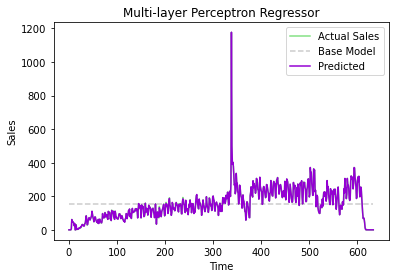

In [26]:
final_mlpr = MLPRegressor(hidden_layer_sizes=(100,30,10),
                          activation='relu',
                          solver='lbfgs',
                          tol=0.005,
                          learning_rate_init=0.1,
                          max_iter=100000)

pipe = make_pipeline(standardize, final_mlpr)

model = pipe.fit(X, y)

y_actual = y
y_base = [y.mean() for i in range(0, len(y))]
y_pred = model.predict(X)

fig, ax = plt.subplots()

ax.plot(y_actual, label='Actual Sales', color='limegreen', alpha=0.6)
ax.plot(y_base, label='Base Model', color='grey', alpha=0.4, linestyle='dashed')
ax.plot(y_pred, label='Predicted', color='darkviolet')

ax.set_title('Multi-layer Perceptron Regressor')
ax.set_xlabel('Time')
ax.set_ylabel('Sales')

ax.legend(loc='upper right')

plt.show()

In [56]:
final_mlpr = MLPRegressor(hidden_layer_sizes=(100,30,10),
                          activation='relu',
                          solver='lbfgs',
                          tol=0.005,
                          learning_rate_init=0.1,
                          max_iter=100000)

pipe = make_pipeline(standardize, final_mlpr)

X_train, y_train = X[:int(len(X)/2)], y[:int(len(X)/2)]
X_test, y_test = X[int(len(X)/2):], y[int(len(X)/2):]

model = pipe.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


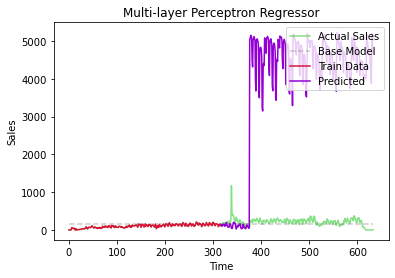

In [57]:
y_actual = y

y_actual_c_train = np.asarray([0 for i in range(0, int(len(X)/2))])
y_actual_c_test = np.asarray([1 for i in range(0, int(len(X)/2))])
y_actual_c = np.concatenate((y_actual_c_train, y_actual_c_test), axis=0)

y_base = [y.mean() for i in range(0, len(y))]

y_pred_on_train = model.predict(X_train)
plot_index_y_pred_on_train = [i for i in range(0, len(y_pred_on_train))]

y_pred_on_new = model.predict(X_test)
plot_index_y_pred_on_new = [i for i in range(len(y_pred_on_train), len(y_pred_on_train)+len(y_pred_on_new))]

fig, ax = plt.subplots()

ax.plot(y_actual, label='Actual Sales', color='limegreen', alpha=0.6)
ax.plot(y_base, label='Base Model', color='grey', alpha=0.4, linestyle='dashed')
# ax.plot(y_pred, label='Predicted', color='darkviolet')
ax.plot(plot_index_y_pred_on_train, y_pred_on_train, label='Train Data', color='crimson')
ax.plot(plot_index_y_pred_on_new, y_pred_on_new, label='Predicted', color='darkviolet')

ax.set_title('Multi-layer Perceptron Regressor')
ax.set_xlabel('Time')
ax.set_ylabel('Sales')

ax.legend(loc='upper right')

plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


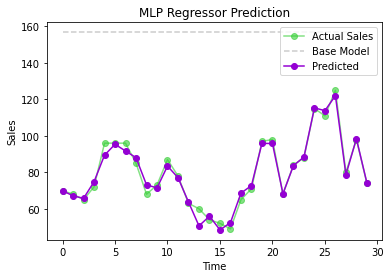

In [27]:
final_mlpr = MLPRegressor(hidden_layer_sizes=(100,30,10),
                          activation='relu',
                          solver='lbfgs',
                          tol=0.005,
                          learning_rate_init=0.3,
                          max_iter=100000)

pipe = make_pipeline(standardize, final_mlpr)

model = pipe.fit(X, y)

y_actual = y
y_base = [y.mean() for i in range(0, len(y))]
y_pred = model.predict(X)

fig, ax = plt.subplots()

ax.plot(y_actual[100:130], label='Actual Sales', color='limegreen', alpha=0.6, marker='o')
ax.plot(y_base[100:130], label='Base Model', color='grey', alpha=0.4, linestyle='dashed')
ax.plot(y_pred[100:130], label='Predicted', color='darkviolet', marker='o')

ax.set_title('MLP Regressor Prediction')
ax.set_xlabel('Time')
ax.set_ylabel('Sales')

ax.legend(loc='upper right')

plt.show()

## Support Vector Regression

In [32]:
from sklearn.svm import LinearSVR

In [33]:
X = model_df.loc[:, ['year', 'month', 'week_num_in_year', 'date', 'day_of_week', 'weekday_flag']].to_numpy()
y = model_df.loc[:, 'count_order'].to_numpy()

### Hyperparameter Tuning

In [30]:
# rmse_scorer = make_scorer(mean_squared_error, squared=False)

# pipe = Pipeline([
#         ('scale', StandardScaler()),
#         ('svr', LinearSVR())])

# param_grid = dict(svr__tol=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5],
#                   svr__max_iter=[10000],
#                   svr__loss=['epsilon_insensitive', 'squared_epsilon_insensitive'],
#                   svr__C=[1, 2, 3, 5, 7, 9, 11, 13])

# grid = GridSearchCV(pipe, param_grid=param_grid, cv=TimeSeriesSplit(),
#                     scoring=rmse_scorer, n_jobs=1, verbose=1)
# grid.fit(X, y)

In [31]:
# print(grid.best_score_)
# print(grid.best_estimator_)

### Default Parameter

In [32]:
svr = LinearSVR()

pipe = make_pipeline(standardize, svr)

_tscv(X, pipe)

[61.76290848592019, 25.25940640058394, 128.95839732815563, 56.275302945612275, 130.18428967537707]
80.48806096712983


### Final Model

In [33]:
final_svr = LinearSVR(C=2, max_iter=2000, tol=0.05)

pipe = make_pipeline(standardize, final_svr)

_tscv(X, pipe)

[41.397137588230414, 22.1579054516713, 126.84422271422387, 56.47042602707716, 138.8970839592855]
77.15335514809765


In [34]:
final_svr = LinearSVR(C=2, max_iter=2000, tol=0.05)

pipe = make_pipeline(standardize, final_svr)

_tscv_eval(X, pipe)

[
    {
        "Median Absolute Error": 30.46797928135703,
        "Mean Absolute Error": 31.869334668566772,
        "Mean Squared Error": 1451.8051593922721,
        "Root Mean Squared Error": 38.10256106080367
    },
    {
        "Median Absolute Error": 16.354305676238027,
        "Mean Absolute Error": 18.984193895611583,
        "Mean Squared Error": 571.6436162115695,
        "Root Mean Squared Error": 23.90906974793393
    },
    {
        "Median Absolute Error": 47.136885546554055,
        "Mean Absolute Error": 64.95790332284135,
        "Mean Squared Error": 15763.731640728342,
        "Root Mean Squared Error": 125.55370022714719
    },
    {
        "Median Absolute Error": 34.25418331908617,
        "Mean Absolute Error": 43.988051277988866,
        "Mean Squared Error": 3179.5913487591415,
        "Root Mean Squared Error": 56.38786526158923
    },
    {
        "Median Absolute Error": 58.05846497218997,
        "Mean Absolute Error": 97.78574101895148,
        "Mean

In [62]:
final_svr = LinearSVR(C=9, max_iter=10000, loss='squared_epsilon_insensitive', tol=1)

pipe = make_pipeline(standardize, final_svr)

_tscv_eval(X, pipe)

[
    {
        "Median Absolute Error": 17.510685499339473,
        "Mean Absolute Error": 22.228392795811025,
        "Mean Squared Error": 802.4679197771682,
        "Root Mean Squared Error": 28.32786472322205
    },
    {
        "Median Absolute Error": 23.519044174980024,
        "Mean Absolute Error": 23.725074315114874,
        "Mean Squared Error": 815.0858722544095,
        "Root Mean Squared Error": 28.54970879456408
    },
    {
        "Median Absolute Error": 92.78984323454225,
        "Mean Absolute Error": 105.11413507621522,
        "Mean Squared Error": 22861.07339315403,
        "Root Mean Squared Error": 151.19878767091365
    },
    {
        "Median Absolute Error": 48.15614247648554,
        "Mean Absolute Error": 55.32553305731226,
        "Mean Squared Error": 4949.527422420178,
        "Root Mean Squared Error": 70.35287785457093
    },
    {
        "Median Absolute Error": 80.29825694358544,
        "Mean Absolute Error": 118.92469140822107,
        "Mean S

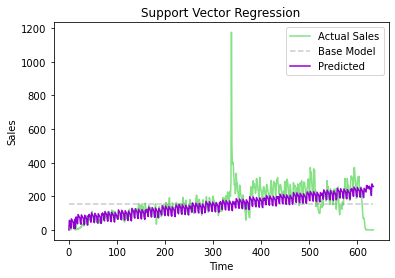

In [35]:
# final_svr = LinearSVR(C=1,
#                       max_iter=10000,
#                       tol=0.5,
#                       epsilon=0.5,
#                       loss='squared_epsilon_insensitive',
#                       dual=False)

# pipe = make_pipeline(standardize, final_svr)

final_svr = LinearSVR(C=1, max_iter=10000, tol=0.05)

pipe = make_pipeline(standardize, final_svr)

model = pipe.fit(X, y)

y_actual = y
y_base = [y.mean() for i in range(0, len(y))]
y_pred = model.predict(X)

fig, ax = plt.subplots()

ax.plot(y_actual, label='Actual Sales', color='limegreen', alpha=0.6)
ax.plot(y_base, label='Base Model', color='grey', alpha=0.4, linestyle='dashed')
ax.plot(y_pred, label='Predicted', color='darkviolet')

ax.set_title('Support Vector Regression')
ax.set_xlabel('Time')
ax.set_ylabel('Sales')

ax.legend(loc='upper right')

plt.show()

In [63]:
final_svr = LinearSVR(C=2, max_iter=10000, tol=0.05)

pipe = make_pipeline(standardize, final_svr)

X_train, y_train = X[:int(len(X)/2)], y[:int(len(X)/2)]
X_test, y_test = X[int(len(X)/2):], y[int(len(X)/2):]

model = pipe.fit(X_train, y_train)

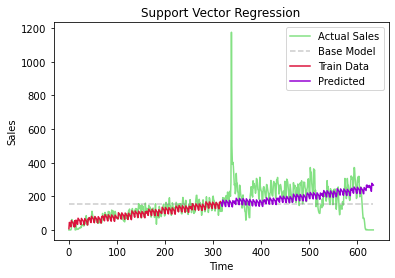

In [64]:
y_actual = y

y_actual_c_train = np.asarray([0 for i in range(0, int(len(X)/2))])
y_actual_c_test = np.asarray([1 for i in range(0, int(len(X)/2))])
y_actual_c = np.concatenate((y_actual_c_train, y_actual_c_test), axis=0)

y_base = [y.mean() for i in range(0, len(y))]

y_pred_on_train = model.predict(X_train)
plot_index_y_pred_on_train = [i for i in range(0, len(y_pred_on_train))]

y_pred_on_new = model.predict(X_test)
plot_index_y_pred_on_new = [i for i in range(len(y_pred_on_train), len(y_pred_on_train)+len(y_pred_on_new))]

fig, ax = plt.subplots()

ax.plot(y_actual, label='Actual Sales', color='limegreen', alpha=0.6)
ax.plot(y_base, label='Base Model', color='grey', alpha=0.4, linestyle='dashed')
# ax.plot(y_pred, label='Predicted', color='darkviolet')
ax.plot(plot_index_y_pred_on_train, y_pred_on_train, label='Train Data', color='crimson')
ax.plot(plot_index_y_pred_on_new, y_pred_on_new, label='Predicted', color='darkviolet')

ax.set_title('Support Vector Regression')
ax.set_xlabel('Time')
ax.set_ylabel('Sales')

ax.legend(loc='upper right')

plt.show()

## SGD Regressor

In [36]:
from sklearn.linear_model import SGDRegressor

In [37]:
X = model_df.loc[:, ['year', 'month', 'week_num_in_year', 'date', 'day_of_week', 'weekday_flag']].to_numpy()
y = model_df.loc[:, 'count_order'].to_numpy()

### Hyperparameter Tuning

In [38]:
rmse_scorer = make_scorer(mean_squared_error, squared=False)

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('sgdr', SGDRegressor())])

param_grid = dict(sgdr__loss=['squared_loss', 'huber'],
                  sgdr__epsilon=[0.1,0.3,0.5,0.7,1],
                  sgdr__learning_rate=['constant', 'invscaling', 'adaptive'],
                  sgdr__eta0=[0.01,0.03,0.05,0.1,0.3,0.5,1,3,5,10],
                  sgdr__max_iter=[5000,10000],
                  sgdr__alpha=[0.0001,0.0005,0.001,0.003])

grid = GridSearchCV(pipe, param_grid=param_grid, cv=TimeSeriesSplit(),
                    scoring=rmse_scorer, n_jobs=1, verbose=1)
grid.fit(X, y)

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:1228: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:1228: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:1228: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:1228: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linea

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('sgdr', SGDRegressor())]),
             n_jobs=1,
             param_grid={'sgdr__alpha': [0.0001, 0.0005, 0.001, 0.003],
                         'sgdr__epsilon': [0.1, 0.3, 0.5, 0.7, 1],
                         'sgdr__eta0': [0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1, 3,
                                        5, 10],
                         'sgdr__learning_rate': ['constant', 'invscaling',
                                                 'adaptive'],
                         'sgdr__loss': ['squared_loss', 'huber'],
                         'sgdr__max_iter': [5000, 10000]},
             scoring=make_scorer(mean_squared_error, squared=False), verbose=1)

In [39]:
print(grid.best_score_)
print(grid.best_estimator_)

84390654763551.08
Pipeline(steps=[('scale', StandardScaler()),
                ('sgdr',
                 SGDRegressor(alpha=0.001, epsilon=0.3, eta0=10,
                              learning_rate='constant', max_iter=10000))])


### Default Parameter & Final Model

In [40]:
sgdr = SGDRegressor()

pipe = make_pipeline(standardize, sgdr)

_tscv(X, pipe)

[31.888688591740948, 31.710158612231353, 124.11087933758397, 65.42426010002924, 156.6957099473011]
81.96593931777733


In [41]:
sgdr = SGDRegressor()

pipe = make_pipeline(standardize, sgdr)

_tscv_eval(X, pipe)

[
    {
        "Median Absolute Error": 22.316574846886596,
        "Mean Absolute Error": 24.953324640969996,
        "Mean Squared Error": 1008.725588260274,
        "Root Mean Squared Error": 31.760440618169547
    },
    {
        "Median Absolute Error": 23.52312572617697,
        "Mean Absolute Error": 25.052689141485164,
        "Mean Squared Error": 998.7330620496263,
        "Root Mean Squared Error": 31.602738204934493
    },
    {
        "Median Absolute Error": 44.99041682491682,
        "Mean Absolute Error": 63.880051759880814,
        "Mean Squared Error": 15387.766999020856,
        "Root Mean Squared Error": 124.04743850245701
    },
    {
        "Median Absolute Error": 36.444858056836836,
        "Mean Absolute Error": 48.479490418983204,
        "Mean Squared Error": 4266.738957243502,
        "Root Mean Squared Error": 65.32027983133187
    },
    {
        "Median Absolute Error": 70.44301144480505,
        "Mean Absolute Error": 115.69139874866215,
        "Me

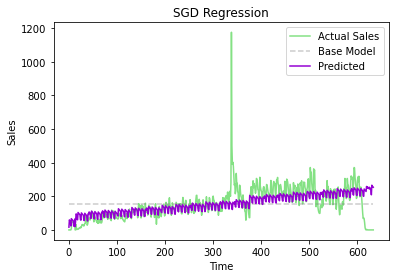

In [42]:
# SGDRegressor(epsilon=0.7, eta0=10, learning_rate='constant',
#                               max_iter=10000)

# sgdr = SGDRegressor(epsilon=0.7,
#                     eta0=0.1,
#                     learning_rate='constant',
#                     max_iter=10000
#                    )

sgdr = SGDRegressor()

pipe = make_pipeline(standardize, sgdr)

model = pipe.fit(X, y)

y_actual = y
y_base = [y.mean() for i in range(0, len(y))]
y_pred = model.predict(X)

fig, ax = plt.subplots()

ax.plot(y_actual, label='Actual Sales', color='limegreen', alpha=0.6)
ax.plot(y_base, label='Base Model', color='grey', alpha=0.4, linestyle='dashed')
ax.plot(y_pred, label='Predicted', color='darkviolet')

ax.set_title('SGD Regression')
ax.set_xlabel('Time')
ax.set_ylabel('Sales')

ax.legend(loc='upper right')

plt.show()

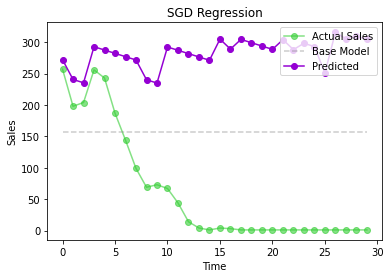

In [43]:
sgdr = SGDRegressor()

pipe = make_pipeline(standardize, sgdr)

model = pipe.fit(X[:len(X)-30], y[:len(y)-30])

y_actual = y[len(y)-30:]
y_base = [y.mean() for i in range(0, 30)]
y_pred = model.predict(X[len(X)-30:])

fig, ax = plt.subplots()

ax.plot(y_actual, label='Actual Sales', color='limegreen', alpha=0.6, marker='o')
ax.plot(y_base, label='Base Model', color='grey', alpha=0.4, linestyle='dashed')
ax.plot(y_pred, label='Predicted', color='darkviolet', marker='o')

ax.set_title('SGD Regression')
ax.set_xlabel('Time')
ax.set_ylabel('Sales')

ax.legend(loc='upper right')

plt.show()

## Random Forest Regression

In [37]:
from sklearn.ensemble import RandomForestRegressor

In [38]:
X = model_df.loc[:, ['year', 'month', 'week_num_in_year', 'date', 'day_of_week', 'weekday_flag']].to_numpy()
y = model_df.loc[:, 'count_order'].to_numpy()

### Hyperparameter Tuning

In [46]:
# rmse_scorer = make_scorer(mean_squared_error, squared=False)

# pipe = Pipeline([
#         ('scale', StandardScaler()),
#         ('rfr', RandomForestRegressor())])

# param_grid = dict(rfr__n_estimators=[100,150,200,250,300],
#                   rfr__criterion=['mae'])

# grid = GridSearchCV(pipe, param_grid=param_grid, cv=TimeSeriesSplit(),
#                     scoring=rmse_scorer, n_jobs=1, verbose=1)
# grid.fit(X, y)

In [47]:
# print(grid.best_score_)
# print(grid.best_estimator_)

### Final Model

In [48]:
rfr = RandomForestRegressor(criterion='mae',
                            n_estimators=300
                           )

pipe = make_pipeline(standardize, rfr)

_tscv_eval(X, pipe)

[
    {
        "Median Absolute Error": 35.95833333333333,
        "Mean Absolute Error": 42.58684126984127,
        "Mean Squared Error": 2976.5488866931214,
        "Root Mean Squared Error": 54.55775734662415
    },
    {
        "Median Absolute Error": 65.56666666666666,
        "Mean Absolute Error": 60.35434920634921,
        "Mean Squared Error": 4952.61265941799,
        "Root Mean Squared Error": 70.37480130997166
    },
    {
        "Median Absolute Error": 136.79,
        "Mean Absolute Error": 138.0734126984127,
        "Mean Squared Error": 34589.18736801587,
        "Root Mean Squared Error": 185.98168557149887
    },
    {
        "Median Absolute Error": 25.47666666666666,
        "Mean Absolute Error": 38.00507936507937,
        "Mean Squared Error": 2575.1132432804234,
        "Root Mean Squared Error": 50.745573632391064
    },
    {
        "Median Absolute Error": 70.71333333333334,
        "Mean Absolute Error": 83.11847619047617,
        "Mean Squared Error": 

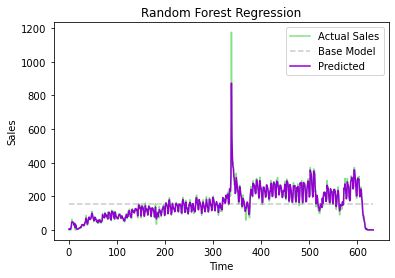

In [49]:
# rfr = RandomForestRegressor()

rfr = RandomForestRegressor(criterion='mae',
                            n_estimators=300
                           )

pipe = make_pipeline(standardize, rfr)

model = pipe.fit(X, y)

y_actual = y
y_base = [y.mean() for i in range(0, len(y))]
y_pred = model.predict(X)

fig, ax = plt.subplots()

ax.plot(y_actual, label='Actual Sales', color='limegreen', alpha=0.6)
ax.plot(y_base, label='Base Model', color='grey', alpha=0.4, linestyle='dashed')
ax.plot(y_pred, label='Predicted', color='darkviolet')

ax.set_title('Random Forest Regression')
ax.set_xlabel('Time')
ax.set_ylabel('Sales')

ax.legend(loc='upper right')

plt.show()

In [69]:
rfr = RandomForestRegressor(criterion='mae',
                            n_estimators=300
                           )

pipe = make_pipeline(standardize, rfr)

X_train, y_train = X[:int(len(X)/2)], y[:int(len(X)/2)]
X_test, y_test = X[int(len(X)/2):], y[int(len(X)/2):]

model = pipe.fit(X_train, y_train)

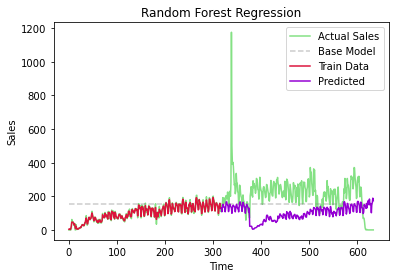

In [70]:
y_actual = y

y_base = [y.mean() for i in range(0, len(y))]

y_pred_on_train = model.predict(X_train)
plot_index_y_pred_on_train = [i for i in range(0, len(y_pred_on_train))]

y_pred_on_new = model.predict(X_test)
plot_index_y_pred_on_new = [i for i in range(len(y_pred_on_train), len(y_pred_on_train)+len(y_pred_on_new))]

fig, ax = plt.subplots()

ax.plot(y_actual, label='Actual Sales', color='limegreen', alpha=0.6)
ax.plot(y_base, label='Base Model', color='grey', alpha=0.4, linestyle='dashed')
# ax.plot(y_pred, label='Predicted', color='darkviolet')
ax.plot(plot_index_y_pred_on_train, y_pred_on_train, label='Train Data', color='crimson')
ax.plot(plot_index_y_pred_on_new, y_pred_on_new, label='Predicted', color='darkviolet')

ax.set_title('Random Forest Regression')
ax.set_xlabel('Time')
ax.set_ylabel('Sales')

ax.legend(loc='upper right')

plt.show()